A simple frequency-based pairing heap:

In [3]:
:ext BangPatterns

import Data.Semigroup     (Semigroup(..))
import Data.List.NonEmpty (NonEmpty(..))
import Data.Foldable      (Foldable(..))

data Heap a =
    Node {-# UNPACK #-} !Int
         !a
         (HeapList a)

infixr 5 :-
data HeapList a
    = Nil
    | (:-) {-# UNPACK #-} !(Heap a)
           (HeapList a)

instance Foldable Heap where
    foldr f b (Node _ x xs) = f x (foldr f b xs)

    foldl' f !b (Node _ x xs) =
        case f b x of
            !b' -> foldl' f b' xs

instance Foldable HeapList where
    foldr _ b Nil                 = b
    foldr f b (Node _ x xs :- ys) = f x (foldr f (foldr f b ys) xs)

    foldl' _ !b Nil = b
    foldl' f !b (Node _ x xs :- ys) =
        case f b x of
            !b' -> case foldl' f b' xs of
              !b'' -> foldl' f b'' ys

instance Semigroup (Heap a) where
    (Node i x xs) <> (Node j y ys)
      | i <= j = Node i x (Node j y ys :- xs)
      | otherwise = Node j y (Node i x xs :- ys)
    sconcat (ys :| [])        = ys
    sconcat (ys :| [zs])      = ys <> zs
    sconcat (ys :| (z:zz:zs)) = (ys <> z) <> sconcat (zz :| zs)

mergeHeaps :: Heap a -> HeapList a -> Heap a
mergeHeaps t Nil               = t
mergeHeaps t1 (t2 :- Nil)      = t1 <> t2
mergeHeaps t1 (t2 :- t3 :- ts) = (t1 <> t2) <> mergeHeaps t3 ts

singleton :: Int -> a -> Heap a
singleton i x = Node i x Nil

insert :: Int -> a -> Heap a -> Heap a
insert !i !x (Node j y ys)
  | i <= j = Node i x (Node j y ys :- Nil)
  | otherwise = Node j y (Node i x Nil :- ys)

insertList :: Int -> a -> HeapList a -> Heap a
insertList !i !x Nil = Node i x Nil
insertList !i !x (y :- ys) = insert i x (mergeHeaps y ys)

A function to count the frequencies of some elements:

In [36]:
import           Data.Map.Strict (Map)
import qualified Data.Map.Strict as Map

newtype Frequencies a
    = Frequencies
    { getFrequencies :: Map a Int
    }

frequencies :: (Ord a, Foldable f) => f a -> Frequencies a
frequencies = Frequencies . foldl' (\m x -> Map.insertWith (+) x 1 m) Map.empty

And a way to show frequencies

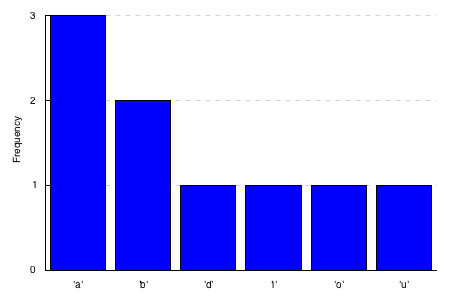

In [51]:
import Graphics.Rendering.Chart
import Data.Default.Class
import Control.Lens
import IHaskell.Display

instance Show a => IHaskellDisplay (Frequencies a) where
    display (Frequencies values)
        = display
        $ toRenderable
        $ layout_x_axis . laxis_generate .~ autoIndexAxis (map show (Map.keys values))
        $ layout_y_axis . laxis_title .~ "Frequency"
        $ layout_plots .~ [ plotBars
                          $ plot_bars_values .~ addIndexes (map pure (Map.elems values))
                          $ def ]
        $ def

:opt svg

frequencies "aaabioubd"

A Huffman tree:

In [37]:
data Tree a
    = Leaf {-# UNPACK #-} !Int a
    | Node